# ECE 57000 Assignment 6 Exercise

Your Name: Souradip Pal

For this assignment, you will implement and explore various density estimation methods.

## Exercise 1: Density estimation in 1D
In this exercise, you will write code to estimate 1D densities.
Specifically, you will write code to estimate a Gaussian density, a histogram density, and a kernel density.

### Task 1.1: Gaussian density
For this first one you will estimate a Gaussian density via MLE.
As discussed in class, this simplifies to estimating the mean and standard deviation of the data and using these empirical estimates for the Gaussian distribution.
The Gaussian PDF can be evaluated using the function [`scipy.stats.norm.pdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html).

In [1]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
class GaussianDensity(BaseEstimator):
    def fit(self, X, y=None):
        ##### Your code here #####
        # You should estimate the mean and variance of the data  and save as self.mean_ and self.std_
        # (note that X will be shape (n,1) because there is only 1 feature).
        self.mean_ = np.mean(X)
        self.std_ = np.std(X)
        
        ##########################
        return self
    
    def predict_proba(self, X):
        ##### Your code here #####
        # This should return the PDF values for each sample in X (again of shape (n, 1))
        # This should use your self.mean_ and self.std_ variables saved from the fit method
        pdf_values = scipy.stats.norm.pdf(X, loc=self.mean_, scale=self.std_).reshape(-1)
        return pdf_values  # Output should be of shape (n,), i.e., a 1D array
        ##########################

### Task 1.2: Histogram density
Now you will implement a histogram density estimate given min, max and number of bins.
The function [`np.searchsorted`](https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html) may be useful but is not required.

NOTE: The value of the histogram outside of the min max values should be set to 0.

In [2]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
class HistogramDensity(BaseEstimator):
    def __init__(self, n_bins, min_val, max_val):
        self.n_bins = n_bins
        self.min_val = min_val
        self.max_val = max_val
    
    def fit(self, X, y=None):
        ##### Your code here #####
        # First create equally spaced bin_edges based on min_val, max_val and n_bins
        #  and save as self.bin_edges_
        #  (note the shape of self.bin_edges_ should be (n_bins+1,) )
        # Second, estimate the frequency for each bin based on the input data X
        #  (i.e., the number of training samples that fall into that bin divided 
        #  by the total number of samples)
        # Third, using the probability for each bin, compute the density value (i.e., PDF) for
        #  each bin. (Note you will have to account for the width of the bin to ensure
        #  that integrating your density function from min_value to max_value will be 1).
        #  Save the density per bin as self.pdf_per_bin_ which should have the shape (n_bins,)
        self.bin_edges_, interval = np.linspace(self.min_val, self.max_val, num=self.n_bins+1, retstep=True)
        frequency = np.zeros(self.n_bins)
        indices = np.searchsorted(self.bin_edges_, X).reshape(-1) - 1
        for index in indices:
            frequency[index] +=1
        frequency = frequency/np.sum(frequency)
        self.pdf_per_bin_ = frequency/interval
        
        ##########################
        return self
    
    def predict_proba(self, X):
        ##### Your code here #####
        # You should return the PDF value of the samples X.  This requires finding out which
        #  bin each sample falls into and returning it's corresponding density value
        #  **Importantly, if the value is less than min_value or greater than max_value, 
        #    then a pdf value of 0 should be returned.
        indices = np.searchsorted(self.bin_edges_, X).reshape(-1) - 1
        pdf_values = np.array([self.pdf_per_bin_[index] if index >= 0 and index<self.n_bins else 0 for index in indices])

        return pdf_values  # Output should be of shape (n,), i.e., a 1D array
        ##########################

### Task 1.3: Kernel density
Now you will implement a kernel density estimate (KDE) via a Gaussian kernel given the bandwidth parameter (i.e., the standard deviation of the Gaussian kernel.
Specifically, the Gaussian kernel density is given by:
$$p(x; \mathcal{D}) = \frac{1}{n}\sum_{i=1}^n p_{\mathcal{N}}(x; \mu = x_i, \sigma=h) $$
where $\mathcal{D}=\{x_i\}_{i=1}^n$ is a training dataset of $n$ samples, $p_{\mathcal{N}}$ is the Gaussian/normal density function and $h$ is called the bandwidth hyperparameter of the KDE model.
(Note that fitting merely requires saving the training dataset and using it to compute densities of new samples.)

In [3]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
class KernelDensity(BaseEstimator):
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    
    def fit(self, X, y=None):
        ##### Your code here #####
        # Save the training data in self.X_train_
        self.X_train_ = X
        ##########################
        return self
    
    def predict_proba(self, X):
        ##### Your code here #####
        # You should return the KDE PDF value of the samples X.
        #  Note that the sum above is over the TRAINING samples, not the test samples
        #  so you should use the samples saved in the fit method.
        mean = self.X_train_.reshape(-1)
        p = np.array([scipy.stats.norm.pdf(X.reshape(-1), loc=x, scale=self.bandwidth) for x in mean])
        pdf_values = np.mean(p, axis=0).reshape(-1)
        return pdf_values  # Output should be of shape (n,), i.e., a 1D array
        ##########################

### Test code
The following code will test each of your density estimators.
Run this to test your code and this is what will be used for grading your code.

(200, 1) (200, 1)
Fitting GaussianDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=0.9999833065912315

Fitting HistogramDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=1.0001081542114805

Fitting KernelDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=1.0000000000000004



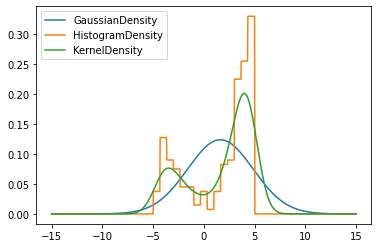

In [4]:
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Generate some data and split into train and test
min_val, max_val = -5, 5
diff = max_val - min_val
X = diff * np.vstack([scipy.stats.beta(6,1).rvs(size=(300,1)), scipy.stats.beta(2,7).rvs(size=(100,1))]) - diff/2
X_train, X_test = train_test_split(X, test_size=0.5, random_state=15)
print(X_train.shape, X_test.shape)

# Loop through models
models = [GaussianDensity(), 
          HistogramDensity(n_bins=15, min_val=min_val, max_val=max_val),
          KernelDensity(bandwidth=1)
         ]
for model in models:
    print(f'Fitting {type(model).__name__} model')
    # Fit models
    model.fit(X_train)

    # Sanity checks 
    xq = np.linspace(min_val-diff, max_val+diff, num=1000)
    pdf_vals = model.predict_proba(xq.reshape(-1, 1))
    # Check that right size and >= 0
    print(f'{len(pdf_vals.shape) == 1 and pdf_vals.shape[0] == len(xq)}, Shape={pdf_vals.shape}'
          f' - Is the output the correct shape?') 
    print(f'{np.all(pdf_vals>=0)}, Num neg={np.sum(pdf_vals < 0)} - Are all pdf values >= 0? ')
    
    # Check that integrates to 1 vai approximate numerical integration
    model_pdf = lambda x: model.predict_proba(np.array(x).reshape(1,1))[0]
    quad_out = scipy.integrate.quad(model_pdf, min_val - diff, max_val + diff, limit=100, full_output=True)
    print(f'quad_out={quad_out[0]}')
    print('')

    # Plot density model
    plt.plot(xq, pdf_vals, label=type(model).__name__)
    
plt.legend()

## Exercise 2: Determine optimal hyperparameters based on 10-fold cross validation
In this exercise, you need to write code that will use your estimators from above to automatically choose the best hyperparameters for the histogram and kernel density estimator.  In particular, find the best `n_bins` and `bandwidth` for the histogram and KDE respectively.

### Task 1: Implement custom scorer function for use in GridSearchCV
To do this, you will need to implement a `scorer` function that will compute the log likelihood of the data given (higher is better).
This function takes in the model, the input data X and y_true (which defaults to None since this is an unsupervised problem).

Since we are computing the log of probabilities, we have to be careful on the case where the probability for a certain sample is zero, since the log(0) is negative infinity. And this phenomenon can happen when we use more and more bins to approximate the density with Histogram density model(Consider the case where the original density value is small for a certain range of x, and when we do sampling on the distribution, there is a high likelihood that none of the sampled points fall into that range, i.e the probability bin will have 0 height on that range). 

One easy way to overcome this issue is to add a small number epsilon (e.g 1e-15) on the probability value that is 0. The code might look like this:
`pdf_vector[pdf_vector<lambda_] = lambda_ # where lambda_ is a small value like 1e-15`

In [5]:
def mean_log_likelihood_scorer(model, X, y_true=None, lambda_=1e-15):
    ########## Your code here ########
    # Compute and return the mean log probability of the data
    #  (Note y_true is not used)
    pdf_values = model.predict_proba(X)
    pdf_values[pdf_values < lambda_] = lambda_

    mean_ll = np.mean(np.log(pdf_values))

    return mean_ll
    ############

### Task 2: Estimate best hyperparameters
Then you can use sklearn's cross validation utilities to cross validate using the training data to determine the best parameters by passing this function as the `scoring` argument of GridSearchCV (note you just pass it directly as `mean_log_likelihood_scorer` without the parenthesis; this is known as passing a function to another function).

You should try 2-20 number of bins and a 50 bandwidth parameters linearly spaced between 0.1 and 10.

Finally, print out the optimal hyperparameters and, using the optimal hyperparameters, print out the log likelihood of the test data for both the histogram and KDE model.

In [6]:
############ Your code here #############
from sklearn.model_selection import GridSearchCV


n_bins = np.arange(2,21)
model = HistogramDensity(n_bins=2, min_val=min_val, max_val=max_val)
parameters = {'n_bins': n_bins}
clf = GridSearchCV(model, parameters, scoring=mean_log_likelihood_scorer)
clf.fit(X_train)
print(f'Optimal hyperparameters for histogram: {clf.best_params_}')
test_score = mean_log_likelihood_scorer(clf.best_estimator_, X_test)
print(f'Mean log likelihood for histogram on test data: {test_score}')

bandwidth = np.linspace(0.1, 10, num=50)
model = KernelDensity(bandwidth=1)
parameters = {'bandwidth': bandwidth}
clf = GridSearchCV(model, parameters, scoring=mean_log_likelihood_scorer)
clf.fit(X_train)
print(f'Optimal hyperparameters for KDE: {clf.best_params_}')
test_score = mean_log_likelihood_scorer(clf.best_estimator_, X_test)
print(f'Mean log likelihood for KDE on test data: {test_score}')


Optimal hyperparameters for histogram: {'n_bins': 6}
Mean log likelihood for histogram on test data: -1.9684606028958462
Optimal hyperparameters for KDE: {'bandwidth': 0.3020408163265306}
Mean log likelihood for KDE on test data: -1.9812904072765818
